---
title: "Implementing the Perceptron Algorithm"
jupyter: ml-0451
format:
  html:
    code-fold: false
---

In [68]:
%load_ext autoreload
%autoreload 2
from perceptron_model import Perceptron, PerceptronOptimizer
from minibatch import MiniBatchPerceptron, MiniBatchPerceptronOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Link to Source Code
The complete perceptron implementation can be found in my [Github repository](https://github.com/username/repository).

# Abstract

This blog post explores the implementation and behavior of the perceptron algorithm. The perceptron serves as a binary linear classifier that learns a decision boundary to separate data into two classes. Through detailed experiments, we investigate the convergence properties of the perceptron on linearly separable and non-separable data, and examine its extension to minibatch learning. By implementing the algorithm from scratch using PyTorch, we gain insights into its mathematical foundations, computational efficiency, and limitations.

# Part A: Implementation

## Implementation Walkthrough
The heart of the perceptron algorithm lies in the `grad()` method, which accurately implements the mathematical update rule:

```python
def grad(self, X, y):
    # Convert y from {0,1} to {-1,1} for perceptron math
    y_ = 2*y - 1
    
    # Compute scores
    scores = self.score(X)
    
    # Identify misclassified points
    misclassified = (scores * y_ <= 0).float()
    
    # Calculate update vector using vectorized operations
    return -torch.sum(misclassified.unsqueeze(1) * y_.unsqueeze(1) * X, dim=0)
```

This implementation directly translates the formula $-1[s_i(2y_i-1) < 0](2y_i-1)x_i$ by:
1. Converting labels to {-1, 1} format
2. Computing whether each point is misclassified using the sign comparison
3. Calculating the update vector in a vectorized manner

To check my implementation on the mini loop, first, let's set up the imports and data generation:

In [69]:
import torch
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-whitegrid')

# Set random seed for reproducibility
torch.manual_seed(1234)

# Function to generate perceptron data
def perceptron_data(n_points=300, noise=0.2, p_dims=2):
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size=(n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    return X, y

# Function to plot perceptron data
def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o", ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s=20, c=2*y[ix]-1, facecolors="none", 
                  edgecolors="darkgrey", cmap="BrBG", vmin=-2, vmax=2, 
                  alpha=0.5, marker=markers[i])
    ax.set(xlabel=r"$x_1$", ylabel=r"$x_2$")

# Function to draw a decision boundary line
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

Next, let's generate and visualize the data:

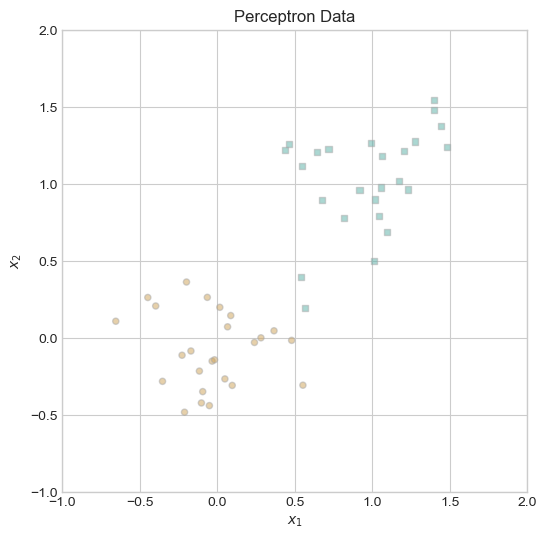

In [70]:
# Generate 2D data with some noise
X, y = perceptron_data(n_points=50, noise=0.3)

# Visualize the data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set(xlim=(-1, 2), ylim=(-1, 2))
plot_perceptron_data(X, y, ax)
plt.title("Perceptron Data")
plt.show()

Now, let's run the perceptron training loop and visualize the results:

In [71]:
# Instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0  # Initial loss
max_iter = 1000  # Safety limit
iter_count = 0

# For keeping track of loss values
loss_vec = []

n = X.size()[0]

# Training loop
while loss > 0 and iter_count < max_iter:  
    loss = p.loss(X, y).item()
    loss_vec.append(loss)
    
    # Pick a random data point
    i = torch.randint(n, size=(1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # Perform a perceptron update using the random data point
    opt.step(x_i, y_i)
    
    iter_count += 1

print(f"Final loss: {loss:.4f}")
print(f"Number of iterations: {iter_count}")

Final loss: 0.0000
Number of iterations: 65


The perceptron algorithm achieves `Loss = 0`, indicating that it has perfectly classified the training data.


Let's visualize the training progress:

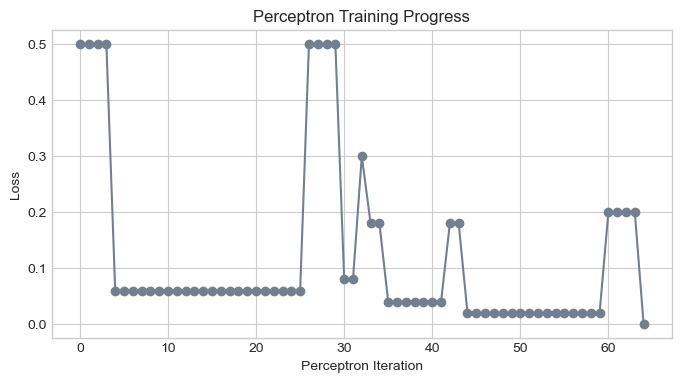

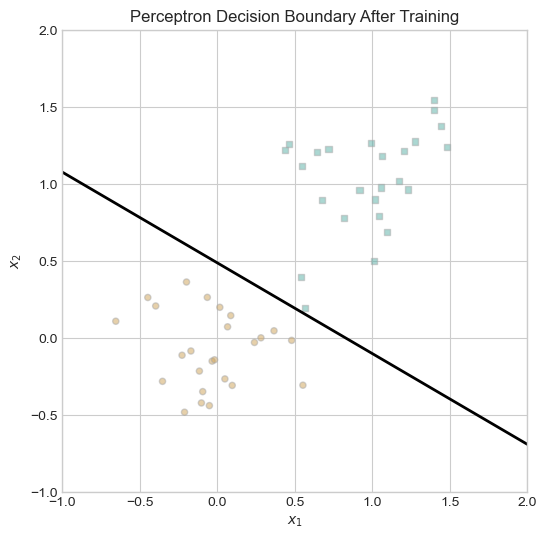

In [72]:
# Plot the loss over iterations
plt.figure(figsize=(8, 4))
plt.plot(loss_vec, color="slategrey")
plt.scatter(np.arange(len(loss_vec)), loss_vec, color="slategrey")
plt.xlabel("Perceptron Iteration")
plt.ylabel("Loss")
plt.title("Perceptron Training Progress")
plt.grid(True)
plt.show()

# Plot the final decision boundary
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set(xlim=(-1, 2), ylim=(-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, -1, 2, ax, color="black", linewidth=2)
plt.title("Perceptron Decision Boundary After Training")
plt.show()

# Part B: Experiments


In this section, we investigate the behavior of the perceptron algorithm under different data conditions, illustrating key properties of the algorithm through three experiments.

Let's start with functions to demonstrate the three experiments

In [73]:
# Set style and random seed
plt.style.use('seaborn-v0_8-whitegrid')
torch.manual_seed(42)

# Helper functions
def generate_non_separable_data(n_points=100):
    """Generate data that is not linearly separable."""
    # Generate two overlapping Gaussian distributions
    n_per_class = n_points // 2
    
    # Class 0: centered at (0, 0)
    X0 = torch.normal(0.0, 0.5, size=(n_per_class, 2))
    
    # Class 1: centered at (0.5, 0.5)
    X1 = torch.normal(0.5, 0.5, size=(n_per_class, 2))
    
    # Combine features
    X = torch.zeros((n_points, 3))  # Include bias term
    X[:n_per_class, :2] = X0
    X[n_per_class:, :2] = X1
    X[:, 2] = 1.0  # Bias term
    
    # Create labels
    y = torch.zeros(n_points)
    y[n_per_class:] = 1
    
    return X, y

def generate_linearly_separable_data(n_points=100, margin=0.1):
    """
    Generate linearly separable data with a clear margin between classes.
    """
    # Generate half points for each class
    n_per_class = n_points // 2
    
    # Class 0: points above the line y = x + margin
    x0 = torch.rand(n_per_class) * 2 - 1  # x values in [-1, 1]
    y0 = x0 + margin + torch.rand(n_per_class) * 0.5  # points above the line
    
    # Class 1: points below the line y = x - margin
    x1 = torch.rand(n_per_class) * 2 - 1  # x values in [-1, 1]
    y1 = x1 - margin - torch.rand(n_per_class) * 0.5  # points below the line
    
    # Combine features
    X = torch.zeros((n_points, 3))  # Include bias term
    X[:n_per_class, 0] = x0
    X[:n_per_class, 1] = y0
    X[n_per_class:, 0] = x1
    X[n_per_class:, 1] = y1
    X[:, 2] = 1.0  # Bias term
    
    # Create labels
    y = torch.zeros(n_points)
    y[n_per_class:] = 1
    
    return X, y

def train_perceptron(X, y, max_iter=1000):
    """Train perceptron and return model, loss history, and iteration count."""
    p = Perceptron()
    opt = PerceptronOptimizer(p)
    
    loss = 1.0
    iter_count = 0
    loss_vec = []
    
    n = X.size()[0]
    
    while loss > 0 and iter_count < max_iter:
        # Track progress
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        
        # Pick a random data point
        i = torch.randint(n, size=(1,))
        x_i = X[[i],:]
        y_i = y[i]
        
        # Perform update
        opt.step(x_i, y_i)
        iter_count += 1
    
    return p, loss_vec, iter_count

Now let's implement the three experiments:

### Experiment 1: Linearly Separable Data

Converged to zero loss: True
Iterations required: 19


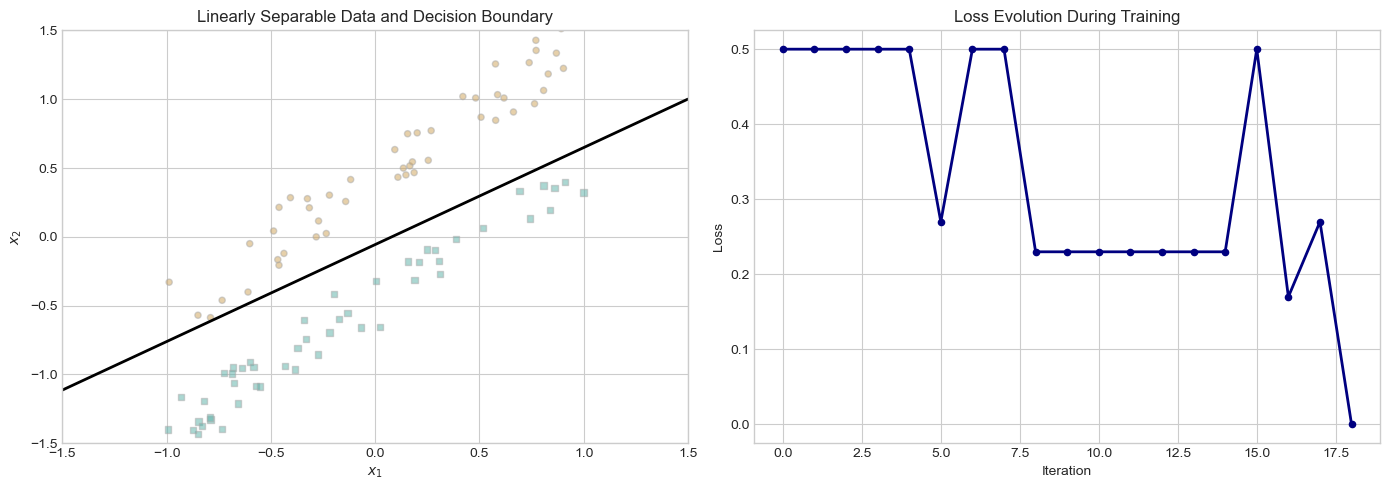

In [74]:
# Generate explicitly separable data
X, y = generate_linearly_separable_data(n_points=100, margin=0.2)

# Train the perceptron
p, loss_vec, iter_count = train_perceptron(X, y)

print(f"Converged to zero loss: {loss_vec[-1] == 0}")
print(f"Iterations required: {iter_count}")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot the data and decision boundary
plot_perceptron_data(X, y, ax1)
draw_line(p.w, -1.5, 1.5, ax1, color="black", linewidth=2)
ax1.set_title("Linearly Separable Data and Decision Boundary")
ax1.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))

# Plot the loss over time
ax2.plot(loss_vec, color="navy", linewidth=2)
ax2.scatter(np.arange(len(loss_vec)), loss_vec, color="navy", s=20)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax2.set_title("Loss Evolution During Training")
ax2.grid(True)

plt.tight_layout()
plt.show()

The perceptron algorithm is guaranteed to converge when data is linearly separable. This experiment demonstrates this property by generating synthetic 2D data that can be perfectly separated by a linear decision boundary.

As shown in the visualization:
- The perceptron successfully finds a decision boundary that perfectly separates the two classes
- The loss decreases, despite some fluctuations, until it reaches zero
- The algorithm terminates once zero-loss is achieved

This confirms the theoretical guarantee that perceptron will converge to a perfect classifier given linearly separable data.

### Experiment 2: Non-Linearly Separable Data

Final loss: 0.1700
Iterations completed: 1000 (max: 1000)


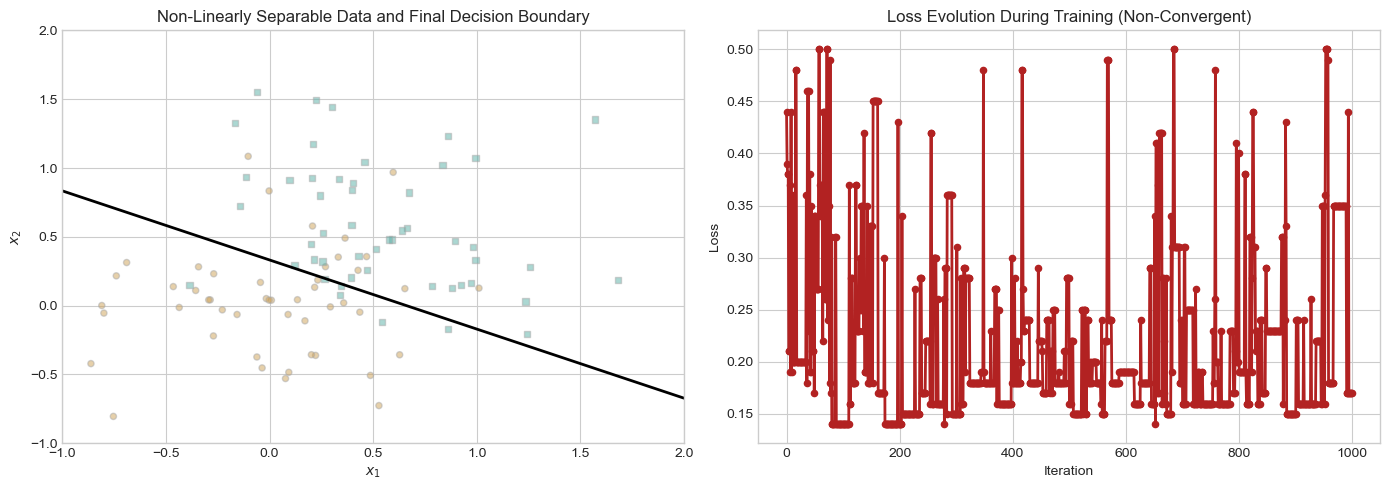

In [75]:
# Generate non-separable data
X, y = generate_non_separable_data(n_points=100)

# Train the perceptron (will hit max_iter)
max_iter = 1000
p, loss_vec, iter_count = train_perceptron(X, y, max_iter=max_iter)

print(f"Final loss: {loss_vec[-1]:.4f}")
print(f"Iterations completed: {iter_count} (max: {max_iter})")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot the data and decision boundary
plot_perceptron_data(X, y, ax1)
draw_line(p.w, -1, 2, ax1, color="black", linewidth=2)
ax1.set_title("Non-Linearly Separable Data and Final Decision Boundary")
ax1.set(xlim=(-1, 2), ylim=(-1, 2))

# Plot the loss over time
ax2.plot(loss_vec, color="firebrick", linewidth=2)
ax2.scatter(np.arange(len(loss_vec)), loss_vec, color="firebrick", s=20)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax2.set_title("Loss Evolution During Training (Non-Convergent)")
ax2.grid(True)

plt.tight_layout()
plt.show()

When data is not linearly separable, the perceptron algorithm will never converge to a perfect classifier. This experiment illustrates this limitation by introducing points that cannot be perfectly separated by any linear boundary.

From the results:
- The algorithm runs until the maximum iteration limit is reached
- The loss never reaches zero and continues to fluctuate
- The final decision boundary still misclassifies some points

This behavior aligns with theoretical expectations: when perfect linear separation is impossible, the perceptron will continue updating without converging to a stable solution.

### Experiment 3: Higher-Dimensional Data

Final loss: 0.0000
Iterations required: 62
Feature dimensions: 5 + bias


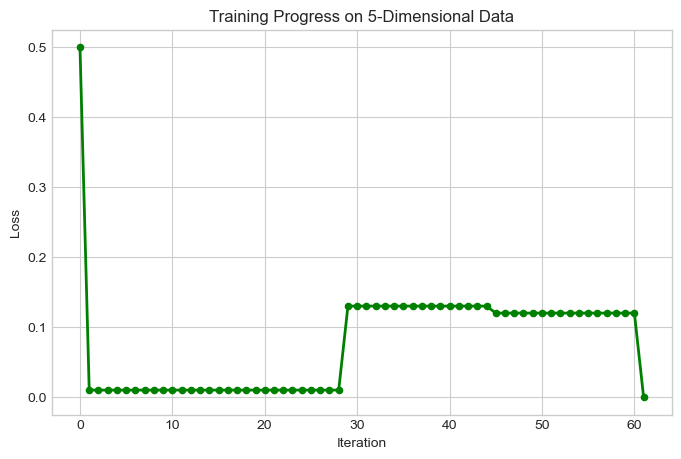

In [76]:
# Generate data with 5 dimensions
n_dims = 5
X, y = perceptron_data(n_points=100, noise=0.2, p_dims=n_dims)

# Train the perceptron
p, loss_vec, iter_count = train_perceptron(X, y)

print(f"Final loss: {loss_vec[-1]:.4f}")
print(f"Iterations required: {iter_count}")
print(f"Feature dimensions: {n_dims} + bias")

# Plot the loss over time
plt.figure(figsize=(8, 5))
plt.plot(loss_vec, color="green", linewidth=2)
plt.scatter(np.arange(len(loss_vec)), loss_vec, color="green", s=20)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Training Progress on {n_dims}-Dimensional Data")
plt.grid(True)
plt.show()

The perceptron algorithm can be applied to data with any number of features. This experiment examines its performance on data with 5 features.

Based on the loss evolution:
- We can observe that the algorithm converges to zero loss
- The zero loss indicates the data is linearly separable in the higher-dimensional space

This demonstrates that the perceptron can effectively classify higher-dimensional data when linear separability exists.

### Runtime Complexity Analysis

**(a) What is the runtime complexity of a single iteration of the perceptron algorithm?**

A single iteration of the perceptron algorithm has a time complexity of O(p), where p is the number of features. This includes:
- O(p) for computing the score (dot product)
- O(1) for checking misclassification
- O(p) for updating the weight vector

**(b) Does the runtime complexity depend on the number of data points n?**

For the perceptron, the runtime of a single iteration does not depend on n. Each iteration processes just one randomly selected data point, making it O(1) with respect to n.

**What about the number of features p?**

The runtime complexity scales linearly with p because both score calculation and weight update require operations on p-dimensional vectors.

**(c) What is the runtime complexity of a single iteration of the minibatch perceptron algorithm?**

For minibatch perceptron with batch size k, time complexity is O(k·p) per iteration

# Part C: Minibatch Perceptron

Experiements with minibatch perceptron

In [77]:
def train_minibatch_perceptron(X, y, batch_size=1, learning_rate=1.0, max_iter=1000):
    """Train perceptron using minibatches."""
    p = MiniBatchPerceptron()
    opt = MiniBatchPerceptronOptimizer(p)
    
    loss = 1.0
    iter_count = 0
    loss_vec = []
    
    n = X.size()[0]
    
    while loss > 0 and iter_count < max_iter:
        # Track progress
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        
        # Sample a random minibatch
        if batch_size == n:  # Full batch
            batch_indices = torch.arange(n)
        else:  # Random minibatch
            batch_indices = torch.randperm(n)[:batch_size]
            
        x_batch = X[batch_indices, :]
        y_batch = y[batch_indices]
        
        # Perform update with learning rate
        opt.step(x_batch, y_batch, learning_rate)
        
        iter_count += 1
    
    return p, loss_vec, iter_count

## Experiment 1: Minibatch with k=1

Batch size: 1
Final loss: 0.0000
Iterations required: 122


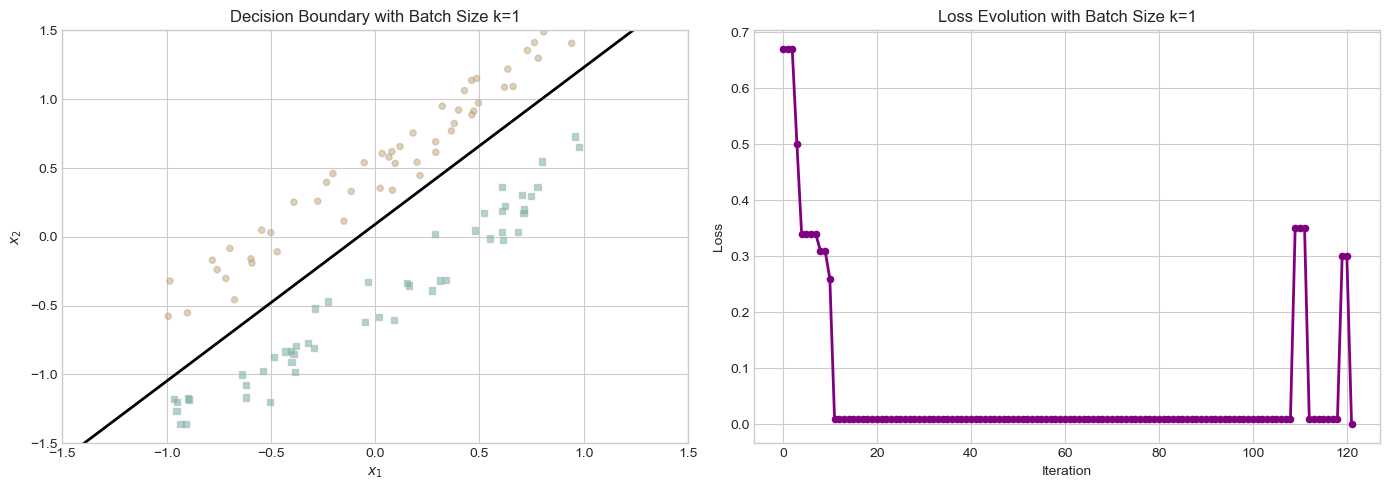

In [78]:
X1, y1 = generate_linearly_separable_data(n_points=100, margin=0.2)
batch_size = 1
p1, loss_vec1, iter_count1 = train_minibatch_perceptron(X1, y1, batch_size=batch_size)

print(f"Batch size: {batch_size}")
print(f"Final loss: {loss_vec1[-1]:.4f}")
print(f"Iterations required: {iter_count1}")

# Visualize Experiment 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plot_perceptron_data(X1, y1, ax1)
draw_line(p1.w, -1.5, 1.5, ax1, color="black", linewidth=2)
ax1.set_title(f"Decision Boundary with Batch Size k={batch_size}")
ax1.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))

ax2.plot(loss_vec1, color="purple", linewidth=2)
ax2.scatter(np.arange(len(loss_vec1)), loss_vec1, color="purple", s=20)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax2.set_title(f"Loss Evolution with Batch Size k={batch_size}")
ax2.grid(True)
plt.tight_layout()
plt.show()

When the batch size k=1, the minibatch perceptron is equivalent to the standard perceptron.

Key observations:
- Updates are based on individual data points
- Convergence is guaranteed for linearly separable data
- The path to convergence can be irregular and depend on the random order of samples

## Experiment 2: Minibatch with k=10

Batch size: 10
Final loss: 0.0000
Iterations required: 2


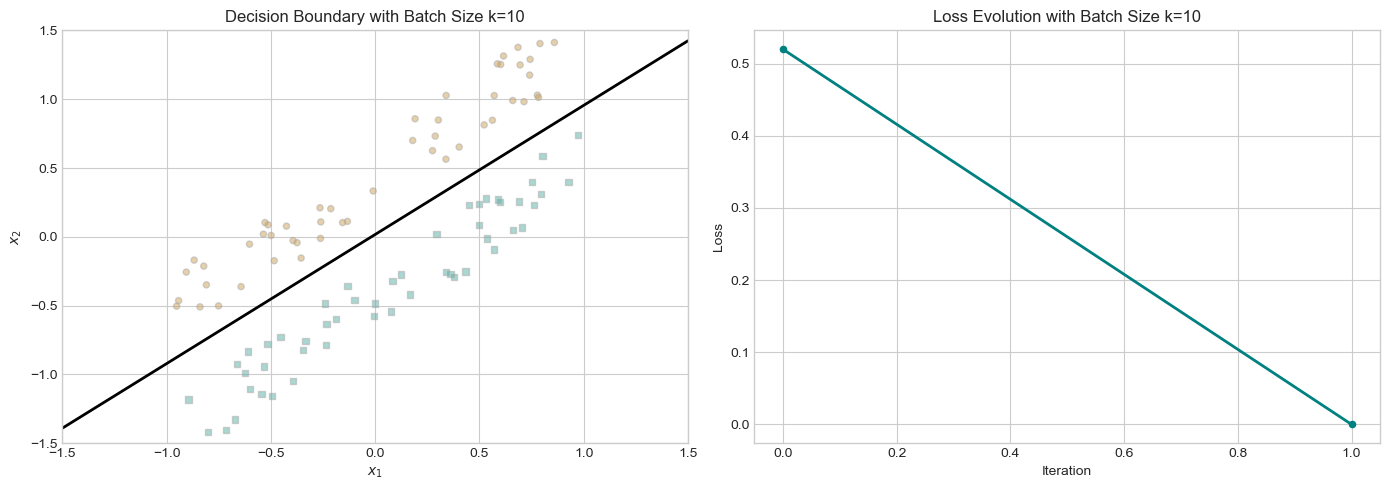

In [79]:
X2, y2 = generate_linearly_separable_data(n_points=100, margin=0.2)
batch_size = 10
p2, loss_vec2, iter_count2 = train_minibatch_perceptron(X2, y2, batch_size=batch_size)

print(f"Batch size: {batch_size}")
print(f"Final loss: {loss_vec2[-1]:.4f}")
print(f"Iterations required: {iter_count2}")

# Visualize Experiment 2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plot_perceptron_data(X2, y2, ax1)
draw_line(p2.w, -1.5, 1.5, ax1, color="black", linewidth=2)
ax1.set_title(f"Decision Boundary with Batch Size k={batch_size}")
ax1.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))

ax2.plot(loss_vec2, color="teal", linewidth=2)
ax2.scatter(np.arange(len(loss_vec2)), loss_vec2, color="teal", s=20)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax2.set_title(f"Loss Evolution with Batch Size k={batch_size}")
ax2.grid(True)
plt.tight_layout()
plt.show()

Using a larger batch size (k=10) allows the algorithm to consider more data points in each update.

Key findings:
- Updates are averaged across 10 data points, potentially stabilizing learning
- The decision boundary typically evolves more smoothly
- Convergence can be more reliable 

## Experiment 3: Full Batch with Small Learning Rate on Non-Separable Data

Batch size: 100
Learning rate: 0.01
Final loss: 0.2400
Iterations completed: 500


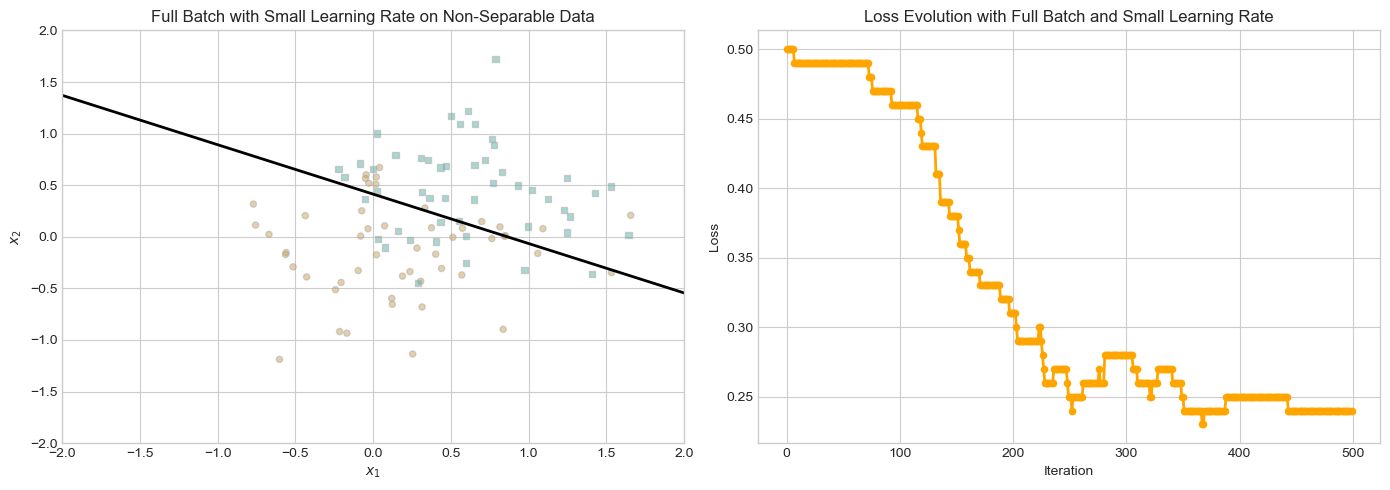

In [82]:
X3, y3 = generate_non_separable_data(n_points=100)
batch_size = X3.size(0)  # Full batch
learning_rate = 0.01  # Small learning rate

p3, loss_vec3, iter_count3 = train_minibatch_perceptron(
    X3, y3, batch_size=batch_size, learning_rate=learning_rate, max_iter=500
)

print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Final loss: {loss_vec3[-1]:.4f}")
print(f"Iterations completed: {iter_count3}")


# Visualize Experiment 3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plot_perceptron_data(X3, y3, ax1)
draw_line(p3.w, -2, 2, ax1, color="black", linewidth=2)
ax1.set_title("Full Batch with Small Learning Rate on Non-Separable Data")
ax1.set(xlim=(-2, 2), ylim=(-2, 2))

ax2.plot(loss_vec3, color="orange", linewidth=2)
ax2.scatter(np.arange(len(loss_vec3)), loss_vec3, color="orange", s=20)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax2.set_title("Loss Evolution with Full Batch and Small Learning Rate")
ax2.grid(True)
plt.tight_layout()
plt.show()

When using the full dataset as a batch (k=n) with a small learning rate on non-separable data:

Notable results:
- The algorithm can converge to a stable solution even on non-separable data
- The small learning rate prevents oscillations that occur with the standard perceptron
- The final decision boundary minimizes misclassification, balancing errors across all classes
- The loss decreases gradually and stabilizes at a non-zero value

This demonstrates an important advantage of the minibatch approach: with proper hyperparameter settings, we can achieve stable solutions even when perfect classification is impossible.

# Conclusion

Throughout this exploration of the perceptron algorithm, we've seen both its strengths and limitations. When data is linearly separable, the perceptron reliably converges to a perfect decision boundary, confirming the theoretical guarantees provided by the Perceptron Convergence Theorem. However, on non-separable data, the algorithm's inability to settle on a stable solution reveals its fundamental constraints.

The minibatch extension offers a promising compromise, allowing faster convergence and more stable learning, particularly when using full-batch updates with small learning rates. This approach can even find meaningful decision boundaries for non-separable data by averaging updates across multiple points.